In [ ]:
from fbpinns.problems import Problem
import jax.numpy as jnp
import jax

class WaveEquation2D(Problem):
    """Solves the time-dependent 1D viscous Burgers equation
        d^2 u       d^2 u    
        ----- - c^2 ----- = 0
        d t^2       d x^2    

        for (x, t) in [0, 1]^2

        Boundary conditions:
        u(0, t) = 0
        u(1, t) = 0
        u(x, 0) = sin(πx) + 0.5 sin(4πx)
        u_t(x, 0) = 0
    """

    @staticmethod
    def init_params(c=jnp.sqrt(2), sd=0.1):

        static_params = {
            "dims":(1,2),
            "c":c,
            "sd":sd,
            }
        
        return static_params, {}

    @staticmethod
    def sample_constraints(all_params, domain, key, sampler, batch_shapes):

        # physics loss
        x_batch_phys = domain.sample_interior(all_params, key, sampler, batch_shapes[0])
        required_ujs_phys = (
            (0,(0,0)),
            (0,(1,1)),
        )
        return [[x_batch_phys, required_ujs_phys],]


    @staticmethod
    def constraining_fn(all_params, x_batch, u):
        sd = all_params["static"]["problem"]["sd"]
        x, t, tanh, sin, pi = x_batch[:,0:1], x_batch[:,1:2], jax.nn.tanh, jnp.sin, jnp.pi
        u = tanh(x/sd) * tanh((1-x)/sd) * t**2 * u  + (sin(pi*x) + 0.5 * sin(4*pi*x))
        return u

    @staticmethod
    def loss_fn(all_params, constraints):
        c = all_params["static"]["problem"]["c"]
        _, uxx, utt = constraints[0]
        phys = utt - c**2 * uxx

        selected = all_params["trainable"]["problem"]["selected"].astype(jnp.int32)
        attention = all_params["trainable"]["attention"]["alpha"][selected]  # (N,1)
        current_i = all_params["trainable"]["problem"]["current_i"]

        mse = jnp.mean(phys**2)
        attention_loss = jnp.mean(
            jnp.exp(-current_i*0.001)*mse + (attention*phys)**2
            )
        jax.debug.print("curr_i = {i}, raw MSE = {m1:.6f}, weighted MSE = {m2:.6f}", i=current_i, m1=mse, m2=attention_loss)
        jax.debug.print("residual max = {a}, attention head = {b}", a=jnp.max(jnp.abs(phys)), b=attention[:5, 0])
        
        return mse, phys
    
    @staticmethod
    def exact_solution(all_params, x_batch, batch_shape):

        c = all_params["static"]["problem"]["c"]
        x, t, sin, cos, pi = x_batch[:,0:1], x_batch[:,1:2], jnp.sin, jnp.cos, jnp.pi
        u = sin(pi*x)*cos(c*pi*t) + 0.5 * sin(4*pi*x)*cos(4*c*pi*t)
        return u

[Errno 16] Device or resource busy: 'results/summaries/test/.nfs000000004808f5a70000268b'
[INFO] 2025-04-21 00:16:12 - <fbpinns.constants.Constants object at 0x7c06f3a1d640>
run: test
domain: <class 'fbpinns.domains.RectangularDomainND'>
domain_init_kwargs: {'xmin': array([0., 0.]), 'xmax': array([1., 1.])}
problem: <class '__main__.WaveEquation2D'>
problem_init_kwargs: {}
decomposition: <class 'fbpinns.decompositions.RectangularDecompositionND'>
decomposition_init_kwargs: {'subdomain_xs': [array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]), array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])], 'subdomain_ws': [array([0.32222222, 0.32222222, 0.32222222, 0.32222222, 0.32222222,
       0.32222222, 0.32222222, 0.32222222, 0.32222222, 0.32222222]), array([0.32222222, 0.32222222, 0.32222222, 0.32222222, 0.32222222,
       0.32

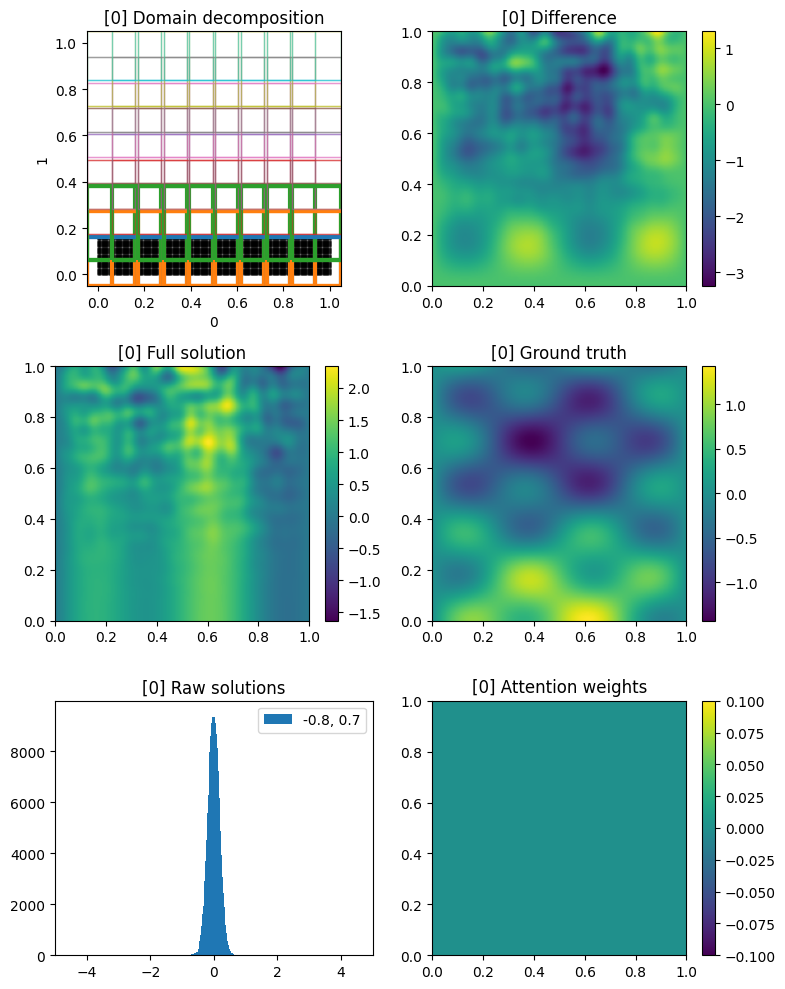

curr_i = [0.], raw MSE = 13103.488281, weighted MSE = 13103.486328
residual max = 266.8988952636719, attention head = [0. 0. 0. 0. 0.]
curr_i = [1.], raw MSE = 13019.345703, weighted MSE = 13006.745117
residual max = 263.0238952636719, attention head = [0.0000000e+00 5.0771399e-07 1.9915356e-06 4.3435398e-06 7.3970573e-06]
curr_i = [2.], raw MSE = 12937.342773, weighted MSE = 12913.125000
residual max = 259.2986755371094, attention head = [0.0000000e+00 1.0273193e-06 4.0301738e-06 8.7916978e-06 1.4977146e-05]
curr_i = [3.], raw MSE = 12857.367188, weighted MSE = 12822.487305
residual max = 255.67066955566406, attention head = [0.0000000e+00 1.5585683e-06 6.1148849e-06 1.3342050e-05 2.2735745e-05]
curr_i = [4.], raw MSE = 12779.392578, weighted MSE = 12734.780273
residual max = 252.11305236816406, attention head = [0.0000000e+00 2.1012070e-06 8.2446659e-06 1.7992381e-05 3.0668998e-05]
curr_i = [5.], raw MSE = 12703.421875, weighted MSE = 12649.984375
residual max = 248.605224609375, att

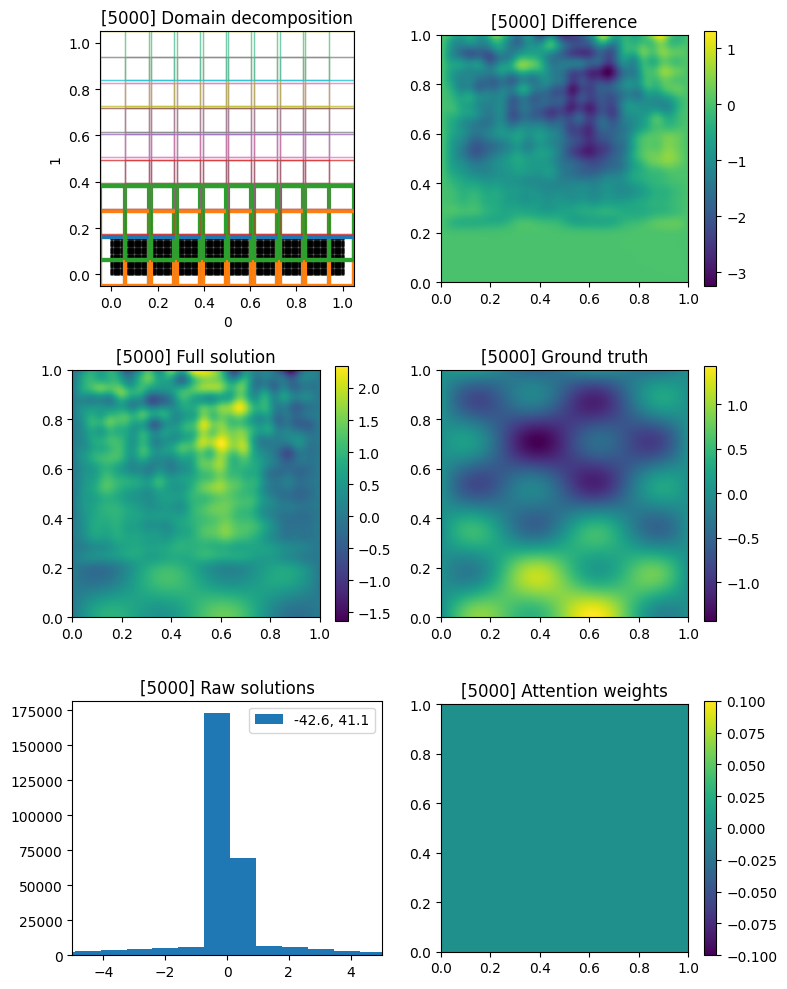

[INFO] 2025-04-21 00:16:34 - curr 5000, decomp 5000
curr_i = [5000.], raw MSE = 12.502239, weighted MSE = 2.793098
residual max = 26.982933044433594, attention head = [0.         0.00879936 0.03328329 0.07000415 0.11516067]
curr_i = [5001.], raw MSE = 12.490983, weighted MSE = 2.789395
residual max = 26.96747589111328, attention head = [0.         0.00880219 0.03329327 0.07002376 0.11519106]
curr_i = [5002.], raw MSE = 12.479751, weighted MSE = 2.785704
residual max = 26.952064514160156, attention head = [0.         0.00880502 0.03330324 0.07004337 0.11522145]
curr_i = [5003.], raw MSE = 12.468523, weighted MSE = 2.782017
residual max = 26.936614990234375, attention head = [0.         0.00880786 0.03331321 0.07006297 0.11525183]
curr_i = [5004.], raw MSE = 12.457322, weighted MSE = 2.778334
residual max = 26.92120361328125, attention head = [0.         0.00881069 0.03332318 0.07008258 0.11528221]
curr_i = [5005.], raw MSE = 12.446136, weighted MSE = 2.774666
residual max = 26.905792236

E0421 00:16:42.377018 1571767 pjrt_stream_executor_client.cc:3077] Execution of replica 0 failed: INTERNAL: CustomCall failed: CpuCallback error: Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/vol/bitbucket/ss7921/dlenv/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
  File "/vol/bitbucket/ss7921/dlenv/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
  File "/vol/bitbucket/ss7921/dlenv/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start
  File "/vol/bitbucket/ss7921/dlenv/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 205, in start
  File "/usr/lib/python3.12/asyncio/base_events.py", line 641, in run_forever
  File "/usr/lib/python3.12/asyncio/base_events.py", line 1987, in _run_once
  File "/usr/lib/python3.12/asyncio/events.py", line 88, in _run
  File "/vol/bitbucket/ss7921/dl

XlaRuntimeError: INTERNAL: CustomCall failed: CpuCallback error: Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/vol/bitbucket/ss7921/dlenv/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
  File "/vol/bitbucket/ss7921/dlenv/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
  File "/vol/bitbucket/ss7921/dlenv/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start
  File "/vol/bitbucket/ss7921/dlenv/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 205, in start
  File "/usr/lib/python3.12/asyncio/base_events.py", line 641, in run_forever
  File "/usr/lib/python3.12/asyncio/base_events.py", line 1987, in _run_once
  File "/usr/lib/python3.12/asyncio/events.py", line 88, in _run
  File "/vol/bitbucket/ss7921/dlenv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue
  File "/vol/bitbucket/ss7921/dlenv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 534, in process_one
  File "/vol/bitbucket/ss7921/dlenv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell
  File "/vol/bitbucket/ss7921/dlenv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 362, in execute_request
  File "/vol/bitbucket/ss7921/dlenv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 778, in execute_request
  File "/vol/bitbucket/ss7921/dlenv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 449, in do_execute
  File "/vol/bitbucket/ss7921/dlenv/lib/python3.12/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
  File "/vol/bitbucket/ss7921/dlenv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell
  File "/vol/bitbucket/ss7921/dlenv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell
  File "/vol/bitbucket/ss7921/dlenv/lib/python3.12/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner
  File "/vol/bitbucket/ss7921/dlenv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async
  File "/vol/bitbucket/ss7921/dlenv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes
  File "/vol/bitbucket/ss7921/dlenv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code
  File "/tmp/ipykernel_1571767/2841998749.py", line 60, in <module>
  File "/vol/bitbucket/ss7921/FBPINNs/fbpinns/trainers.py", line 751, in train
  File "/vol/bitbucket/ss7921/dlenv/lib/python3.12/site-packages/jax/_src/stages.py", line 583, in __call__
  File "/vol/bitbucket/ss7921/dlenv/lib/python3.12/site-packages/jax/_src/stages.py", line 580, in cpp_call_fallback
  File "/vol/bitbucket/ss7921/dlenv/lib/python3.12/site-packages/jax/_src/stages.py", line 552, in call
  File "/vol/bitbucket/ss7921/dlenv/lib/python3.12/site-packages/jax/_src/interpreters/pxla.py", line 3150, in call
  File "/vol/bitbucket/ss7921/dlenv/lib/python3.12/site-packages/jax/_src/profiler.py", line 334, in wrapper
  File "/vol/bitbucket/ss7921/dlenv/lib/python3.12/site-packages/jax/_src/interpreters/pxla.py", line 1288, in __call__
  File "/vol/bitbucket/ss7921/dlenv/lib/python3.12/site-packages/jax/_src/callback.py", line 777, in _wrapped_callback
KeyboardInterrupt: 

In [6]:
import numpy as np

from fbpinns.domains import RectangularDomainND
from fbpinns.decompositions import RectangularDecompositionND
from fbpinns.networks import FCN, ChebyshevKAN, ChebyshevAdaptiveKAN
from fbpinns.schedulers import LineSchedulerRectangularND
from fbpinns.constants import Constants, get_subdomain_ws
from fbpinns.trainers import FBPINNTrainer
from fbpinns.attention import RBAttention

subdomain_xs=[np.linspace(0,1,10), np.linspace(0,1,10)]
c = Constants(
    domain=RectangularDomainND,
    domain_init_kwargs = dict(
        xmin=np.array([0.,0.]),
        xmax=np.array([1.,1.])
        ),
    problem=WaveEquation2D,
    problem_init_kwargs = dict(
        # c=2
    ),
    decomposition=RectangularDecompositionND,
    decomposition_init_kwargs=dict(
        subdomain_xs=subdomain_xs,
        subdomain_ws=get_subdomain_ws(subdomain_xs, 2.9),
        unnorm=(0.,5.),
    ),
    # network=FCN,
    # network_init_kwargs = dict(
    #     layer_sizes = (2, 32, 1),
    # ),
    network=ChebyshevKAN,
    # network=ChebyshevAdaptiveKAN,
    network_init_kwargs=dict(
        input_dim=2,
        output_dim=1,
        degree=10
    ),
    scheduler = LineSchedulerRectangularND,
    scheduler_kwargs = dict(
        point=[0.], iaxis=0,
    ),
    optimiser_kwargs = dict(
        learning_rate=0.001
        ),
    ns=((200,200),),
    n_test=(200,200),
    n_steps=100000,
    clear_output=False,
    attention_tracker=RBAttention,
    attention_tracking_kwargs=dict(
        eta_lr = 1e-2,
        gamma_decay = 0.99,
        out_dim=1,
        N=40000
        ),
    )

run = FBPINNTrainer(c)
all_params = run.train()

In [ ]:
all_params

{'static': {'domain': {'xd': 2,
   'xmin': Array([0., 0.], dtype=float32),
   'xmax': Array([1., 1.], dtype=float32)},
  'problem': {'dims': (1, 2),
   'c': Array(1.4142135, dtype=float32, weak_type=True),
   'sd': 0.1},
  'decomposition': {'m': 100,
   'xd': 2,
   'subdomain': {'params': [Array([[-0.16111112, -0.16111112],
            [-0.16111112, -0.05      ],
            [-0.16111112,  0.06111111],
            [-0.16111112,  0.17222223],
            [-0.16111112,  0.28333333],
            [-0.16111112,  0.39444444],
            [-0.16111112,  0.50555557],
            [-0.16111112,  0.6166667 ],
            [-0.16111112,  0.7277778 ],
            [-0.16111112,  0.8388889 ],
            [-0.05      , -0.16111112],
            [-0.05      , -0.05      ],
            [-0.05      ,  0.06111111],
            [-0.05      ,  0.17222223],
            [-0.05      ,  0.28333333],
            [-0.05      ,  0.39444444],
            [-0.05      ,  0.50555557],
            [-0.05      ,  0.61666